# Microscopic structure

We use the radial distribution function $g(r)$ as a way t understand the microscopic structure of a fluid. It is defined as the probability of finding another atom a distance $r$ away from the atom we are currently perusing.
We normalize the radial distribution function by dividing it with the average particle density $\rho$ such that $\lim_{r \to \infty} g(r) = 1$.

In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)

In [158]:
%%writefile scripts/rdf.in

# 3d Lennard-Jones gas
units lj
dimension 3
# Periodic boundiaries
boundary p p p
atom_style atomic

variable sigma equal 3.405
variable b equal 5.72
variable reduced_density equal 4/((${b}/${sigma})^3)

lattice fcc ${reduced_density}
region simbox block 0 10 0 10 0 10
create_box 1 simbox
create_atoms 1 box

mass 1 1.0
variable T equal 0.1
velocity all create ${T} 87287 dist uniform

variable cut equal 3.0
pair_style lj/cut ${cut}
pair_coeff 1 1 1.0 1.0

variable bins equal 50
compute myRDF all rdf ${bins}
fix 1 all ave/time 100 1 100 c_myRDF[*] file dat/rdf.log mode vector
fix 2 all nvt temp ${T} ${T} 1.0

#dump 1 all custom 10 ${dump_name} id type x y z vx vy vz
thermo 100
run 5000

Overwriting scripts/rdf.in


In [159]:
!export OMP_NUM_THREADS=4 && \
    mpirun -np 4 lmp -in scripts/rdf.in

LAMMPS (4 Jan 2019)
  using 4 OpenMP thread(s) per MPI task
Lattice spacing in x,y,z = 1.67988 1.67988 1.67988
Created orthogonal box = (0 0 0) to (16.7988 16.7988 16.7988)
  1 by 2 by 2 MPI processor grid
Created 4000 atoms
  Time spent = 0.00134862 secs
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 3.3
  ghost atom cutoff = 3.3
  binsize = 1.65, bins = 11 11 11
  2 neighbor lists, perpetual/occasional/extra = 1 1 0
  (1) pair lj/cut, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/3d/newton
      bin: standard
  (2) compute rdf, occasional, copy from (1)
      attributes: half, newton on
      pair build: copy
      stencil: none
      bin: none
Setting up Verlet run ...
  Unit style    : lj
  Current step  : 0
  Time step     : 0.005
Per MPI rank memory allocation (min/avg/max) = 7.373 | 7.373 | 7.373 Mbytes
Step Temp

In [160]:
n = 0
key = None
bin_centers = {}
g_r = {}

with open(os.path.join("dat", "rdf.log"), "r") as f:
    for line in f:
        if line.startswith("#"):
            continue

        line = line.split()
        if len(line) == 2:
            key = int(line[0])
            n = int(line[1])

            bin_centers[key] = []
            g_r[key] = []
            continue

        bin_centers[key].append(float(line[1]))
        g_r[key].append(float(line[2]))

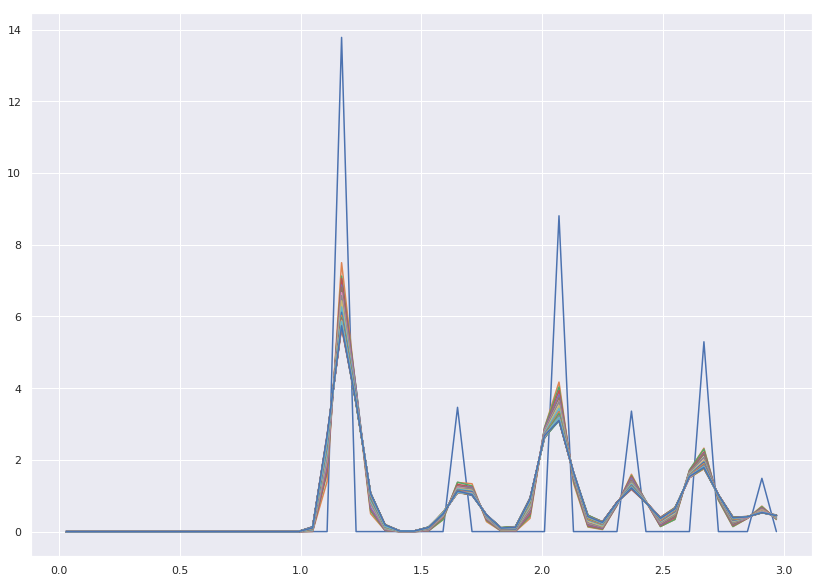

In [161]:
fig = plt.figure(figsize=(14, 10))

for i, key in enumerate(bin_centers):
    if key > 5000:
        break
    plt.plot(
        bin_centers[key],
        g_r[key]
    )
plt.show()